# Digging deeper into weights, GPT-2 huggingface transformer

In [11]:
from transformers import GPT2LMHeadModel

In [12]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict() 


for k, v in sd_hf.items():
	print(k, v.shape)
	

/Users/shivam13juna/Documents/virtual_envs/appy/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [13]:
# calculating total number of parameters
total_params = 0
for k, v in sd_hf.items():
	total_params += v.numel()
print(f"Total number of parameters in millions: {total_params / 1e6:.2f}")
print(f"Total number of parameters in billions: {total_params / 1e9:.2f}")

Total number of parameters in millions: 163.04
Total number of parameters in billions: 0.16


In [14]:
sd_hf['transformer.h.0.ln_1.weight'][:10]

tensor([0.2232, 0.1820, 0.1534, 0.1917, 0.2036, 0.1948, 0.1467, 0.1865, 0.2143,
        0.1956])

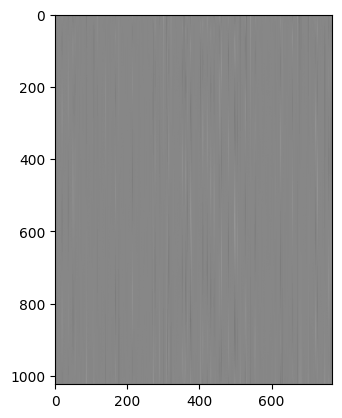

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

In [16]:
sd_hf["transformer.wpe.weight"].shape

torch.Size([1024, 768])

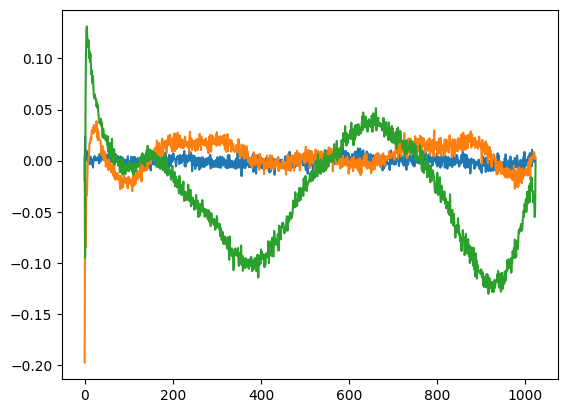

In [17]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 0])
plt.plot(sd_hf["transformer.wpe.weight"][:, 1])
plt.plot(sd_hf["transformer.wpe.weight"][:, 2])

In [18]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2-xl')
set_seed(42)
generated_texts = generator(
	"That's why he got married, trump loves beating his ",
	max_length=100,
	num_return_sequences=5
)

for i, output in enumerate(generated_texts, start=1):
	print(f"Sequence {i}:\n{output['generated_text']}\n")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sequence 1:
That's why he got married, trump loves beating his __________. Trump doesn't want to be caught crying about his mother."

When asked if there's one thing he would change about his presidency, Bill Clinton said "if I could, I'd get rid of [the Confederate flag]."

But he says he'd continue to work with Democrats to pass more gun laws.

"We want to get rid of the gun lobby and all of these crazy laws that they want

Sequence 2:
That's why he got married, trump loves beating his iphone, and why he'd gladly beat a boy with brown hair. This, my brother! And not a moment sooner, or he'd have kissed you."

"The reason Trump's the new Pope," said Harry, "is that he likes to beat his phone up so much, even Pope Berlusconi would be ashamed. When I was a young man, I used to like to beat phones too, but now it

Sequence 3:
That's why he got married, trump loves beating his _____ down.

I think Trump would be one of the best presidents ever. He's one of a kind, all he wants to do is be

In [19]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline, set_seed

# pick the MPS device if available, else fall back to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# load model+tokenizer, move model to mps
model = GPT2LMHeadModel.from_pretrained("gpt2-xl").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")


In [20]:
model.device

device(type='mps', index=0)

# Synthesizing/Generating text with GPT-2

In [21]:
import torch
import time
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline, set_seed

# pick the MPS device if available, else fall back to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# load model+tokenizer, move model to mps
model = GPT2LMHeadModel.from_pretrained("gpt2-xl").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")

# print where the model lives
print("model device:", next(model.parameters()).device)

# run a quick timing check
inp = tokenizer("Hello world", return_tensors="pt").to(model.device)
start = time.time()
_ = model(**inp)
print(f"single forward pass: {time.time() - start:.3f}s")

model device: mps:0
single forward pass: 0.054s


In [22]:

# build your pipeline using the already‑moved model
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device='mps'               # None tells HF to respect model.device
)

generated_texts = generator(
	"Here's the solution to happiness: ",
	max_length=100,
	num_return_sequences=5
)

for i, output in enumerate(generated_texts, start=1):
	print(f"Sequence {i}:\n{output['generated_text']}\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sequence 1:
Here's the solution to happiness:  if you want to be happy, you need to change who you are.  And the first step is to stop being the person on the receiving end of your feelings for people you find unattractive.  Because being unattractive is a big part of the reason people struggle with happiness.  What you really should be feeling is this is a terrible thing that sucks for me.  I'm going to get it repaired.  I

Sequence 2:
Here's the solution to happiness: __________________

Sociopaths don't care about other people's happiness. They care about their own.

Sequence 3:
Here's the solution to happiness:  This isn't how you make a career.  This doesn't mean you have to quit your jobs.  This simply means you are going to have to sacrifice your income from one (or more) of them to get where you're always going to want to be...
...which probably won't be at all where you'd like it to be.  That's the problem with having children.  You can only get them once

Sequence 4:
Here's t

In [23]:
import torch
import time

# print where the model lives
print("model device:", next(model.parameters()).device)

# run a quick timing check
inp = tokenizer("Hello world", return_tensors="pt").to(model.device)
start = time.time()
_ = model(**inp)
print(f"single forward pass: {time.time() - start:.3f}s")

model device: mps:0
single forward pass: 0.049s


In [24]:
import torch
assert torch.backends.mps.is_available(), "MPS not available on this machine"